#### iLQR for point mass example with obstacle (single integrator)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Steps:

#### 1. Define the dynamical system (e.g., double integrator, 2d robot, n-d manipulator, etc.)
#### 2. Define the cost functions
#### 3. Construct the ILQR problem
#### 4. Solve

#### Create point mass system with dimension 2 (double integrator)

In [27]:
class SingleIntegrator():
    def __init__(self,A,B):
        self.A = A
        self.B = B
        self.Dx = A.shape[0]
        self.Du = B.shape[1]
        
    def reset_AB(self, A,B):
        self.A = A
        self.B = B
        
    def set_init_state(self,x0):
        self.x0 = x0
    
    def compute_matrices(self,x,u):
        #compute the derivatives of the dynamics
        return self.A,self.B
    
    def compute_ee(self,x, ee_id=1):
        #The end-effector for a point mass system is simply its position
        #The ee_id is added as dummy variable, just for uniformity of notation with other systems
        return x, None 
    
    def compute_Jacobian(self,x, ee_id=1):
        #The end-effector Jacobian for a point mass system is simply an identity matrix
        #The ee_id is added as dummy variable, just for uniformity of notation with other systems
        return np.eye(int(self.Dx)) 
    
    
    def step(self, x, u):
        return self.A.dot(x) + self.B.dot(u)
    
    def rollout(self,us):
        x_cur = self.x0
        xs = [x_cur]
        T = len(us)
        for i in range(T):
            x_cur = self.step(x_cur, us[i])
            xs += [x_cur]
        return np.array(xs)

In [28]:
dt = 0.01  #duration of 1 time step
T = 100    #total number of time steps
Dx, Du = 2, 2 #dimensions of x and u

#Define the matrix A and B to define a double integrator
A = np.eye(Dx)
B = np.eye(Du)*dt

sys = SingleIntegrator(A, B)

#### Set initial state and control trajectory

In [29]:
x0 = np.zeros(Dx)
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [61]:
Q = np.eye(sys.Dx)*0.  #coefficient for running cost
Qf = np.eye(sys.Dx)*1000  #coefficient for terminal cost
R = np.eye(sys.Du)*0.01  #control coefficient
mu = 1e-6              #regularization coefficient

#### Set reference target

In [62]:
x_target = np.array([3, 3])

#### Set obstacle

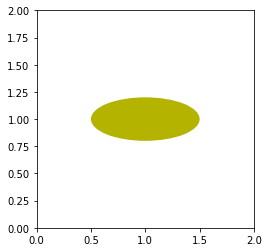

In [76]:
p_obs1 = np.array([1.,1.])   #obstacle position
r_obs1 = np.array([0.5, 0.2]) #radius of the ellipse
ori_obs1 = 0  #rotate the ellipse clockwise
w_obs1 = 100   #weight of the obstacle cost

#compute the covariance matrix of the ellipse
Sigma_obs1 = compute_covariance(r_obs1, ori_obs1)


#plot the ellipse
fig, ax = plt.subplots()
plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
ax.set_xlim(0, 2)
ax.set_ylim(0,2)
ax.set_aspect('equal')

### iLQR using cost model

#### Define the cost

In [81]:
#The costs consist of: a) state tracking (Q), b) control regularization (R), c) obstacle cost
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_target)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningObstacleCost = CostModelCollisionEllipsoidNew(sys, p_obs1, Sigma_obs1, w_obs1)    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_target)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalObstacleCost = CostModelCollisionEllipsoidNew(sys, p_obs1, Sigma_obs1, w_obs1)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [82]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)    #set initial guess

#### Solve and Plot

In [83]:
n_iter = 30
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us
clear_output()

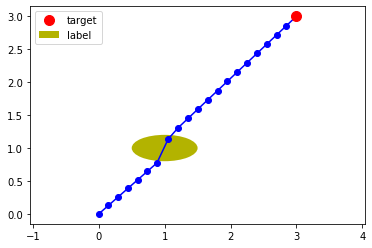

In [84]:
fig, ax = plt.subplots()
ax.plot(xs_batch[::5,0], xs_batch[::5,1], 'b-o')
ax.plot(x_target[0], x_target[1], 'or', markersize = 10, label='target')
plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
ax.legend()
plt.axis('equal')
plt.show()

In [71]:
class CostModelCollisionEllipsoidOld():
    '''
    The collision cost model between the end-effector and an ellipsoid obstacle
    '''
    def __init__(self, sys, p_obs, Sigma_obs, ee_id, w_obs = 1., d_thres = 1., R_obs = None):
        self.sys = sys
        self.Dx, self.Du = sys.Dx, sys.Du
        self.p_obs = p_obs #obstacle position
        self.Sigma_obs = Sigma_obs #obstacle ellipse covariance matrix       
        self.Sigma_obs_inv = np.linalg.inv(Sigma_obs)
        
        
        if R_obs is not None:
            self.R_obs = R_obs #orientation of the obstacle w.r.t. the world
            self.Sigma_obs_inv = self.R_obs.dot(self.Sigma_obs_inv).dot(self.R_obs.T) #transform the cost coefficient to the object frame    

        self.w_obs = w_obs
        self.d_thres = d_thres
        self.obs_status = False
        self.ee_id = ee_id
        
    def calc(self, x, u):
        p,_ = self.sys.compute_ee(x, self.ee_id)
        self.normalized_d = (p-self.p_obs).T.dot(self.Sigma_obs_inv).dot(p-self.p_obs) 
        if self.normalized_d < self.d_thres:
            self.obs_status = True #very near to the obstacle
            self.L = 0.5*self.w_obs*(self.normalized_d-self.d_thres)**2
        else:
            self.obs_status = False
            self.L = 0
        return self.L
    
    def calcDiff(self, x, u, recalc = True):
        if recalc:
            self.calc(x, u)
        self.J   = self.sys.compute_Jacobian(x, self.ee_id)[:3]  #Only use the translation part
        p,_      = self.sys.compute_ee(x, self.ee_id)
        
        if self.obs_status:
            Jtemp = self.J.T.dot(self.Sigma_obs_inv).dot(p-self.p_obs)
            self.Lx = np.zeros(self.Dx)
            self.Lx[:]  = self.w_obs*Jtemp.dot(self.normalized_d-self.d_thres)
            self.Lxx = np.zeros((self.Dx, self.Dx))
            self.Lxx = self.w_obs*Jtemp.T.dot(Jtemp)
        else:
            self.Lx = np.zeros(self.Dx)
            self.Lxx = np.zeros((self.Dx, self.Dx))
        
        self.Lu  = np.zeros(self.Du)
        self.Lxu = np.zeros((self.Dx, self.Du))
        self.Luu  = np.zeros((self.Du, self.Du))
        

In [20]:
class CostModelCollisionEllipsoidNew():
    '''
    The collision cost model between the end-effector and an ellipsoid obstacle
    '''
    def __init__(self, sys, p_obs, Sigma_obs, ee_id, w_obs = 1., d_thres = 1., R_obs = None):
        self.sys = sys
        self.Dx, self.Du = sys.Dx, sys.Du
        self.p_obs = p_obs #obstacle position
        self.Sigma_obs = Sigma_obs #obstacle ellipse covariance matrix       
        self.Sigma_obs_inv = np.linalg.inv(Sigma_obs)
        
        
        if R_obs is not None:
            self.R_obs = R_obs #orientation of the obstacle w.r.t. the world
            self.Sigma_obs_inv = self.R_obs.dot(self.Sigma_obs_inv).dot(self.R_obs.T) #transform the cost coefficient to the object frame    

        self.w_obs = w_obs
        self.d_thres = d_thres
        self.obs_status = False
        self.ee_id = ee_id
        
    def calc(self, x, u):
        p,_ = self.sys.compute_ee(x, self.ee_id)
        self.normalized_d = (p-self.p_obs).T.dot(self.Sigma_obs_inv).dot(p-self.p_obs) 
        if self.normalized_d < self.d_thres:
            self.obs_status = True #very near to the obstacle
            self.L = self.d_thres-0.5*self.w_obs*self.normalized_d
        else:
            self.obs_status = False
            self.L = 0
        return self.L
    
    def calcDiff(self, x, u, recalc = True):
        if recalc:
            self.calc(x, u)
        self.J   = self.sys.compute_Jacobian(x, self.ee_id)[:3]  #Only use the translation part
        p,_      = self.sys.compute_ee(x, self.ee_id)
        
        if self.obs_status:
            Jtemp = -self.J.T.dot(self.Sigma_obs_inv).dot(p-self.p_obs)
            self.Lx = np.zeros(self.Dx)
            self.Lx[:]  = self.w_obs*Jtemp
            self.Lxx = np.zeros((self.Dx, self.Dx))
            self.Lxx= self.w_obs*self.J.T.dot(self.Sigma_obs_inv).dot(self.J)
        else:
            self.Lx = np.zeros(self.Dx)
            self.Lxx = np.zeros((self.Dx, self.Dx))
        
        self.Lu  = np.zeros(self.Du)
        self.Lxu = np.zeros((self.Dx, self.Du))
        self.Luu  = np.zeros((self.Du, self.Du))

In [80]:
idx = np.random.randint(len(ilqr_cost.xs))
idx = 40
x = ilqr_cost.xs[idx]
u = ilqr_cost.us[idx]

inc = 0.001
J = np.zeros((1, len(x)))
for i in range(len(xs[0])):
    x_p = x.copy()
    x_p[i] += inc
    cost_p = runningObstacleCost.calc(x_p, u)
    
    x_m = x.copy()
    x_m[i] -= inc
    cost_m = runningObstacleCost.calc(x_m, u)
    
    diff = (cost_p-cost_m)/(2*inc)
    J[0,i] = diff
    
J_true = runningObstacleCost.calcDiff(x, u)
J_true = runningObstacleCost.Lx
print(J)
print(J_true)
print(J-J_true)

[[ 0.4543 -1.3989  0.      0.    ]]
[ 0.4543 -1.3989  0.      0.    ]
[[0. 0. 0. 0.]]
